In [1]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 256
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor()
])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
class GAN(pl.LightningModule):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.latent_dim = 100
        self.generator = generator
        self.discriminator = discriminator
    
    
    def forward(self, z):
        return self.generator(z) 
    
    
    def sample_z(self, batch_size):
        return torch.randn(batch_size, self.latent_dim)
    
    
    def generator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)
        
        z = self.sample_z(imgs.shape[0])
        z = z.type_as(imgs)
        
        g_loss = F.binary_cross_entropy(self.discriminator(self(z)), valid)
        
        return g_loss
    
    
    def discriminator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        real_loss = F.binary_cross_entropy(self.discriminator(imgs), valid)
    
        z = self.sample_z(imgs.shape[0])
        z = z.type_as(imgs)
        
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)
        
        fake_loss = F.binary_cross_entropy(self.discriminator(self(z).detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        
        return d_loss
    
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        # generator
        if optimizer_idx == 0:
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
            
            g_loss = self.generator_step(imgs)
            self.log('train_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return g_loss
        # discriminator
        elif optimizer_idx == 1:
            d_loss = self.discriminator_step(imgs)
            self.log('train_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return d_loss
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        g_loss = self.generator_step(imgs)
        d_loss = self.discriminator_step(imgs)
        
        self.log('valid_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
    
        
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        return [opt_g, opt_d], []


callbacks = [
    ModelCheckpoint(monitor='valid_g_loss', save_top_k=3, dirpath='weights/GAN', filename='GAN-{epoch:03d}-{valid_g_loss:.4f}-{valid_d_loss:.4f}'),
]

    
generator = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh()
)

discriminator = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)
    
model = GAN(generator, discriminator)
trainer = pl.Trainer(gpus=1, max_epochs=30, enable_progress_bar=True, callbacks=callbacks)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model, train_dataloader, valid_dataloader)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/ubuntu/Workspace/PapersWithCode_GenerativeModels/weights/GAN exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type       | Params
---------------------------------------------
0 | generator     | Sequential | 227 K 
1 | discriminator | Sequential | 201 K 
---------------------------------------------
428 K     Trainable params
0         Non-trainable params
428 K     Total params
1.714     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

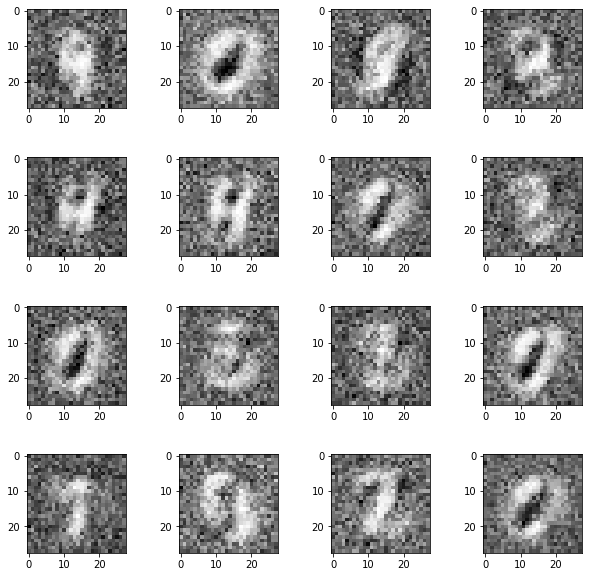

In [4]:
ckpt_fname = "GAN-epoch=003-valid_g_loss=0.9218-valid_d_loss=0.5202.ckpt"
model = model.load_from_checkpoint("weights/GAN/" + ckpt_fname, generator=generator, discriminator=discriminator)

samples = model(torch.randn(16, 100)).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()